In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
### Set up the pauli ops
I,X,Y,Z = np.matrix([[1,0],[0,1]]),np.matrix([[0,1],[1,0]]),np.matrix([[0,-1j],[1j,0]]),np.matrix([[1,0],[0,-1]])
[X0,Y0,Z0] = [np.kron(op,I) for op in [X,Y,Z]]
[X1,Y1,Z1] = [np.kron(I,op) for op in [X,Y,Z]]

In [3]:
from scipy.linalg import expm
def evolve(pulses, dt, H0, H_ops):
    """
    Compute the operator associated with a set of pulses
    
    (List[List[Float]]) pulses: The pulses. Each element should have length equal length
    (Float) dt: duration of each pulse
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    """
    U = np.identity(len(H0))
    for i in range(len(pulses[0])): 
        H = H0
        for k in range(len(pulses)):
            H = H + pulses[k][i] * H_ops[k]
        U=expm(-1j * dt * H) @ U
    return U
def getFidelity(dt, H0, H_ops,target):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        pulses = np.split(coeffs,len(H_ops))
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  -1 * fidelity 
    return loss 

In [4]:
import scipy
###Control and drift
H_ops = [Z0,X0,Y1,Z0@X1]
H_labels = [r'$Z_{0}$', r'$X_{0}$', r'$Y_{1}$', r'$Z_{0}X_1$']
H0 = Z0+Z1
CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=CNOT)
                    ,x0=u0, bounds = [[-10,10]]*N*len(H_ops)
                 )
print("CNOT Fidelity: "+str(-1 * result.fun))

CNOT Fidelity: 0.9999999508258792


In [5]:
###The parameterized lookup table we want
def excitation(theta):
    return expm(1j * theta/2 * (X0@ Y1 - Y0 @ X1))

In [6]:
T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

coefficients = []
fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.zeros(N*len(H_ops))
    if(theta == 0):
        u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
        u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    else:
        u0 = coefficients[len(coefficients)-1] #If we have a pulse, use the most recent one
    result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                        ,x0=u0
                     )
    coefficients.append(result.x)
    fidelities.append(result.fun)
    print("Angle "+str(theta)+" completed with fidelity "+str(-1 * result.fun))

Angle 0.0 completed with fidelity 0.9999998959949931
Angle 0.3306939635357677 completed with fidelity 0.9999999997492077
Angle 0.6613879270715354 completed with fidelity 0.9999999994655562
Angle 0.992081890607303 completed with fidelity 0.9999999978510685
Angle 1.3227758541430708 completed with fidelity 0.9999999997299776
Angle 1.6534698176788385 completed with fidelity 0.9999999993995763
Angle 1.984163781214606 completed with fidelity 0.9999999995457941
Angle 2.3148577447503738 completed with fidelity 0.9999999993964643
Angle 2.6455517082861415 completed with fidelity 0.9999999993517167
Angle 2.9762456718219092 completed with fidelity 0.9999999997440241
Angle 3.306939635357677 completed with fidelity 0.9999999998065117
Angle 3.6376335988934447 completed with fidelity 0.9999999991813731
Angle 3.968327562429212 completed with fidelity 0.9999999996747735
Angle 4.29902152596498 completed with fidelity 0.9999999997979752
Angle 4.6297154895007475 completed with fidelity 0.9999999998428437
A

In [7]:
coefficients = np.array(coefficients)
def interpolate(theta,x,coefficients):
    coeffs = np.zeros(N*len(H_ops))
    for i in range(N*len(H_ops)):
        coeffs[i]=np.interp(x=theta,xp= x,fp=coefficients.T[i])
    return coeffs

In [8]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,np.linspace(0,2*np.pi,20),coefficients)))

Text(0, 0.5, 'fidelity')

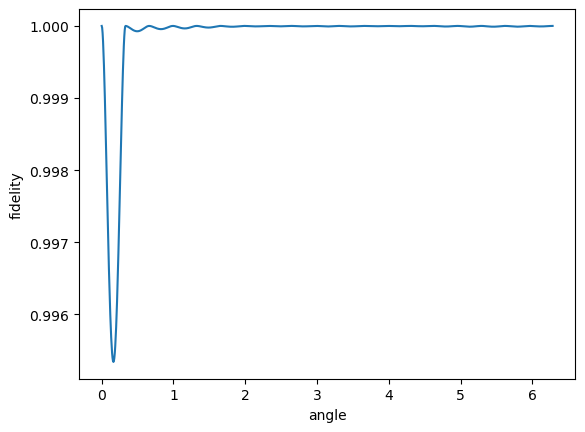

In [9]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [10]:
thetac = min(x, key = lambda v : y[list(x).index(v)])
print("Problem Angle: "+str(thetac))

Problem Angle: 0.16352634433100022


In [11]:
new_coefficients = []
new_fidelities = []
theta_list = list(np.linspace(0,2*np.pi,20))+[thetac]
theta_list.sort()
for theta in theta_list:
    u0 = np.zeros(N*len(H_ops))
    if(theta==0):
        u0 = coefficients[0]
    else:
        u0 = new_coefficients[len(new_coefficients)-1]
    result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                        ,x0=u0
                     )
    new_coefficients.append(result.x)
    new_fidelities.append(-1*result.fun)
    print("------------")
    print("Angle "+str(theta))
    print("Loss "+str(result.fun))
    f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
    print("Fidelity "+str(f))


------------
Angle 0.0
Loss -0.9999998959949931
Fidelity 0.9999998959949931
------------
Angle 0.16352634433100022
Loss -0.9999999987719972
Fidelity 0.9999999987719972
------------
Angle 0.3306939635357677
Loss -0.9999999989701752
Fidelity 0.9999999989701752
------------
Angle 0.6613879270715354
Loss -0.9999999998294209
Fidelity 0.9999999998294209
------------
Angle 0.992081890607303
Loss -0.9999999996308944
Fidelity 0.9999999996308944
------------
Angle 1.3227758541430708
Loss -0.9999999998984415
Fidelity 0.9999999998984415
------------
Angle 1.6534698176788385
Loss -0.999999999869339
Fidelity 0.999999999869339
------------
Angle 1.984163781214606
Loss -0.9999999999090288
Fidelity 0.9999999999090288
------------
Angle 2.3148577447503738
Loss -0.9999999999117684
Fidelity 0.9999999999117684
------------
Angle 2.6455517082861415
Loss -0.999999999855073
Fidelity 0.999999999855073
------------
Angle 2.9762456718219092
Loss -0.9999999997737452
Fidelity 0.9999999997737452
------------
Angle 

In [12]:
new_coefficients=np.array(new_coefficients)
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,theta_list,new_coefficients)))

Text(0, 0.5, 'fidelity')

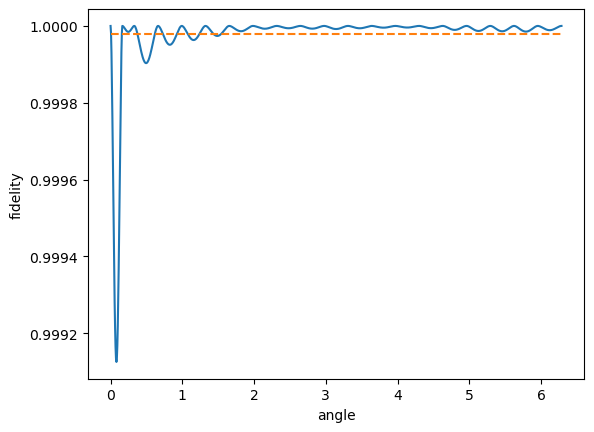

In [13]:
plt.plot(x,y)
plt.plot(x,[np.mean(y)]*len(x),'--')
plt.xlabel("angle")
plt.ylabel("fidelity")

In [14]:
print("Mean Fidelity: "+str(np.mean(y)))
print("Max Fidelity: "+str(np.max(y)))
print("Min Fidelity: "+str(np.min(y)))
print("Largest Amplitude: "+str(np.max(np.abs(new_coefficients))))

Mean Fidelity: 0.9999782981727126
Max Fidelity: 0.9999999997225841
Min Fidelity: 0.999125343421519
Largest Amplitude: 2.3517672373436986
